<a href="https://colab.research.google.com/github/ioloi1128/CDA/blob/main/CDA_week9_EOF_Method.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install numpy
!pip install xarray
!pip install matplotlib
!pip install scipy
!pip install pandas

!apt-get install libproj-dev proj-data proj-bin
!apt-get install libgeos-dev
!pip install cython
!pip install cartopy

!apt-get -V -y -qq install python-cartopy python3-cartopy
!pip uninstall shapely -y
!pip install shapely --no-binary shapely

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 39 not upgraded.
Need to get 32.3 kB of archives.
After this operation, 110 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 proj-bin amd64 4.9.3-2 [32.3 kB]
Fetched 32.3 kB in 0s (560 kB/s)
Selecting previously unselected package proj-bin.
(Reading database ... 155455 files and directories currently installed.)
Preparing to unpack .../proj-bin_4.9.3-2_amd64.deb ...
Unpacking proj-bin (4.9.3-2) ...
Setting up proj-bin (4.9.3-2) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Reading package lists... Done
Building dependency tree       
Reading state 

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point

Read in monthly SST

In [3]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.oisst.v2/sst.mnmean.nc'
ds = xr.open_dataset(url)

# select period
ds = ds.sel(time=slice('1980', '2000'))

#actually load the data
ds.load()

<xarray.Dataset>
Dimensions:    (lat: 180, lon: 360, nbnds: 2, time: 229)
Coordinates:
  * lat        (lat) float32 89.5 88.5 87.5 86.5 ... -86.5 -87.5 -88.5 -89.5
  * lon        (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * time       (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) datetime64[ns] 1981-12-01 1982-01-01 ... 2001-01-01
    sst        (time, lat, lon) float32 -1.79 -1.79 -1.79 ... -1.79 -1.79 -1.79
Attributes:
    title:                           NOAA Optimum Interpolation (OI) SST V2
    Conventions:                     CF-1.0
    history:                         Wed Apr  6 13:47:45 2005: ncks -d time,0...
    comments:                        Data described in  Reynolds, R.W., N.A. ...
    platform:                        Model
    source:                          NCEP Climate Modeling Branch
    institution:                     National Centers for Environmental Predi...
    References:                      https://www.psl.noaa.gov/data/gridded/da...
    dataset_title:                   NOAA Optimum Interpolation (OI) SST V2
    source_url:                      http://www.emc.ncep.noaa.gov/research/cm...
    DODS_EXTRA.Unlimited_Dimension:  time

Make anomalies

In [4]:
ds_climo=ds.groupby('time.month').mean()
ds_anoms=ds.groupby('time.month')-ds_climo
ds_anoms

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 229)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 5.96e-07 5.96e-07 ... 5.96e-07 5.96e-07

Reversed latitudes

In [5]:
ds_anoms=ds_anoms.reindex(lat=list(reversed(ds_anoms['lat'])))

Select Tropical Pacific Region

<xarray.Dataset>
Dimensions:  (lat: 60, lon: 250, time: 229)
Coordinates:
  * lat      (lat) float32 -29.5 -28.5 -27.5 -26.5 -25.5 ... 26.5 27.5 28.5 29.5
  * lon      (lon) float32 30.5 31.5 32.5 33.5 34.5 ... 276.5 277.5 278.5 279.5
  * time     (time) datetime64[ns] 1981-12-01 1982-01-01 ... 2000-12-01
    month    (time) int64 12 1 2 3 4 5 6 7 8 9 10 ... 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst      (time, lat, lon) float32 -0.09 -0.029 0.1415 ... -0.622 -0.4825

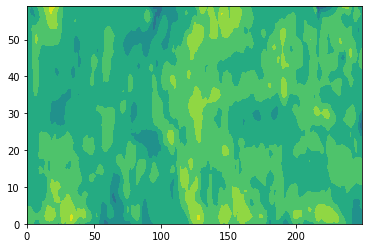

In [6]:
ds_tpac=ds_anoms.sel(lat=slice(-30,30),lon=slice(30,280))
plt.contourf(ds_tpac['sst'][0,:,:])
ds_tpac

Weight data

In [7]:
coslat = np.cos(np.deg2rad(ds_tpac.coords['lat'].values))
wgts = np.sqrt(coslat)[..., np.newaxis]
ds_tpac=ds_tpac*wgts
wgts.shape

(60, 1)

Reshape to [time,space]

In [8]:
nx=len(ds_tpac['lon'])
ny=len(ds_tpac['lat'])
nt=len(ds_tpac['time'])
X=np.reshape(ds_tpac['sst'].values,((nt,ny*nx)))
X.shape

(229, 15000)

Calculation of EOFs

Calculate the Covariance Matrix

In [9]:
C=np.cov(X)
C.shape

(229, 229)

Calculate the eigenvalues and vectors of the Covariance Matrix

In [10]:
from numpy import linalg as LA

In [11]:
eigenvalues,eigenvectors=LA.eig(C)

Sort eigenvalues and eigenvectors

In [12]:
idx = eigenvalues.argsort()[::-1]   
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]

Get the PC Temporal Patterns

In [13]:
PC=eigenvectors
PC.shape

(229, 229)

Plot the first PC (the one with the most variance)

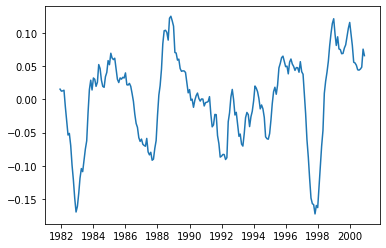

In [14]:
plt.plot(ds_anoms['time'],PC[:,0])

Get the EOF Spatial Patterns

In [15]:
EOF=np.dot(X.T,PC)
EOF=EOF.reshape((ny,nx,nt)).T/wgts.squeeze()
EOF.shape

(229, 250, 60)

Plot the first EOF (the one with the most variance)

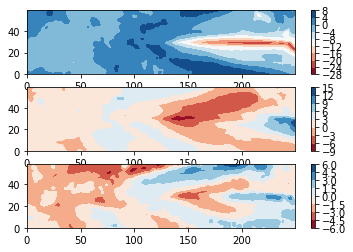

In [16]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    plt.contourf(EOF[i,:,:].T,cmap='RdBu')
    plt.colorbar()

Get the variance explained by each eigenvector

[34.33443116 10.53735008  4.08574991  3.77723239  3.18924273  2.63126807
  2.19878242  2.14794283  1.78802596  1.57818816]


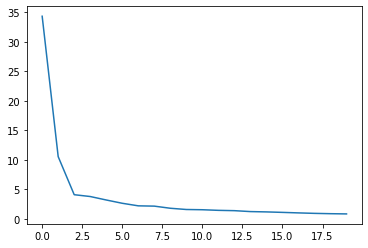

In [17]:
vexp=eigenvalues/np.sum(eigenvalues)
plt.plot(vexp[0:20]*100)
print(vexp[0:10]*100)

Presenting EOFs

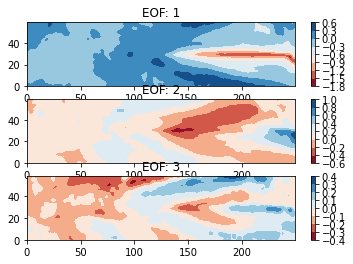

In [18]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=EOF[i,:,:].T*np.std(PC[:,i])
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

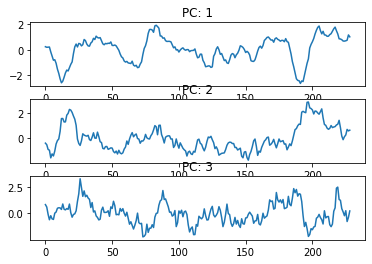

In [19]:
nrows=3
ncols=1
clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    pcnorm=PC[:,i]/np.std(PC[:,i])
    plt.title('PC: '+str(i+1))
    plt.plot(pcnorm)

**Method II: pyEOF**

In [20]:
pip install pyEOF

  Created wheel for pyEOF: filename=pyEOF-0.0.0-py3-none-any.whl size=9363 sha256=94d12a1c59b6491f08c45cda75e93589c742d2929608ff8959502c29d4ee23c9
  Stored in directory: /root/.cache/pip/wheels/87/61/3e/865b808f717a570881db4fdce827cd5155796e03286e17b72f
Successfully built pyEOF


In [21]:
from pyEOF import *
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [22]:
def visualization(da, pcs, eofs_da, evf):
    fig = plt.figure(figsize = (6,12))

    ax = fig.add_subplot(n+1,2,1)
    da.mean(dim=["lat","lon"]).plot(ax=ax)
    ax.set_title("average surface temp")

    ax = fig.add_subplot(n+1,2,2)
    da.mean(dim="time").plot(ax=ax)
    ax.set_title("average surface temp")

    for i in range(1,n+1):
        pc_i = pcs["PC"+str(i)].to_xarray()
        eof_i = eofs_da.sel(EOF=i)["sst"]
        frac = str(np.array(evf[i-1]*100).round(2))

        ax = fig.add_subplot(n+1,2,i*2+1)
        pc_i.plot(ax=ax)
        ax.set_title("PC"+str(i)+" ("+frac+"%)")

        ax = fig.add_subplot(n+1,2,i*2+2)
        eof_i.plot(ax=ax,
                   vmin=-2, vmax=2, cmap="RdBu_r",
                   cbar_kwargs={'label': ""})
        ax.set_title("EOF"+str(i)+" ("+frac+"%)")

    plt.tight_layout()
    plt.show()

%matplotlib inline

In [23]:
df = ds_tpac.to_dataframe().reset_index() # get df from da
#df=np.transpose(df1)

display(df.head(5))
print("DataFrame Shape:",df.shape)

,lat,lon,time,month,sst
0,-29.5,30.5,1981-12-01,12,-0.083964
1,-29.5,30.5,1982-01-01,1,0.009819
2,-29.5,30.5,1982-02-01,2,-0.446823
3,-29.5,30.5,1982-03-01,3,0.040263
4,-29.5,30.5,1982-04-01,4,0.213589


DataFrame Shape: (3435000, 5)


In [24]:
df_data = get_time_space(df, time_dim = "time", lumped_space_dims = ["lat","lon"])
display(df_data.head(5))
print("DataFrame Shape:",df_data.shape)

month                                                        ...  \
lat        -29.5                                                        ...   
lon        30.5  31.5  32.5  33.5  34.5  35.5  36.5  37.5  38.5  39.5   ...   
time                                                                    ...   
1981-12-01    12    12    12    12    12    12    12    12    12    12  ...   
1982-01-01     1     1     1     1     1     1     1     1     1     1  ...   
1982-02-01     2     2     2     2     2     2     2     2     2     2  ...   
1982-03-01     3     3     3     3     3     3     3     3     3     3  ...   
1982-04-01     4     4     4     4     4     4     4     4     4     4  ...   

                 sst                                                    \
lat             29.5                                                     
lon            270.5     271.5     272.5     273.5     274.5     275.5   
time                                                                     
1981-12-01  0.571886  0.260754 -0.174922 -0.132474  0.118949  0.291540   
1982-01-01  1.323285  0.935384  0.581361  0.694785  1.004616  1.149957   
1982-02-01  2.400080  2.226264  2.276346  2.432978  2.694688  2.743302   
1982-03-01  1.940982  2.087306  2.200730  2.416775  2.609746  2.458513   
1982-04-01  1.133752  1.299227  1.091528  1.193658  1.290389  1.283513   

                                                    
lat                                                 
lon            276.5     277.5     278.5     279.5  
time                                                
1981-12-01 -0.048977 -0.098888 -0.216438 -0.422151  
1982-01-01  0.774332  0.225376 -0.577434 -0.724247  
1982-02-01  2.527257  1.566340  0.431604  0.296574  
1982-03-01  2.222332  1.391537  0.377593  0.439951  
1982-04-01  1.667979  1.222139  0.513110  0.590691  

[5 rows x 30000 columns]

DataFrame Shape: (229, 30000)


        Parameters
        ----------
        s : 
            Scaling
            0 : Un-scaled PCs (default).
            1 : PCs are divided by the square-root of the eigenvalue.
            2 : PCs are multiplied by the square-root of the eigenvalue.
        n :
            Number of PCs to retrieve.

In [25]:
n = 4 # define the number of components

pca = df_eof(df_data) # implement EOF

eofs = pca.eofs(s=2, n=n) # get eofs
eofs_da = eofs.stack(["lat","lon"]).to_xarray() # make it convenient for visualization
pcs = pca.pcs(s=2, n=n) # get pcs
evfs = pca.evf(n=n) # get variance fraction

# plot
#visualization(ds_tpac['sst'], pcs, eofs_da, evfs)

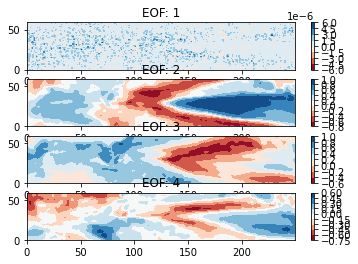

In [26]:
nrows=4
ncols=1
#clevs=np.arange(-20,21,10)

for i in np.arange(4):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=eofs_da['sst'][i,:,:]
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()

**Method III: sklearn**

In [27]:
!pip install eofs

     |████████████████████████████████| 1.0 MB 9.5 MB/s 
  Created wheel for eofs: filename=eofs-1.4.0-py3-none-any.whl size=1100374 sha256=3147ba47feec0f2d7c21da53df26b69653eacb76ebf69ff7b1aa6e945523166b
  Stored in directory: /root/.cache/pip/wheels/ce/4e/36/2ef48d7342cd326d5f3bdb4ddd0441f06b387b5cbfc8336095
Successfully built eofs


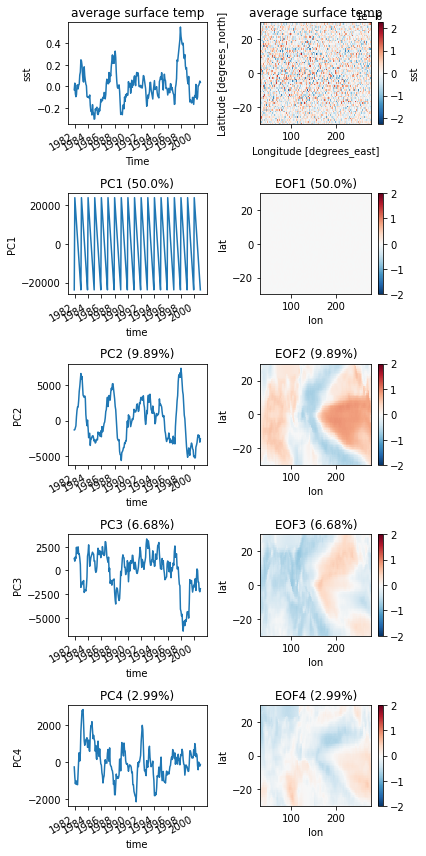

In [28]:
from eofs.standard import Eof
from sklearn.preprocessing import StandardScaler
solver = Eof(StandardScaler().fit_transform(df_data.values))

s_pcs = pd.DataFrame(data=solver.pcs(npcs=4, pcscaling=2),
                     columns = pcs.columns,
                     index = pcs.index)


s_eofs = pd.DataFrame(data = solver.eofs(neofs=4, eofscaling=2),
                      columns = eofs.columns,
                      index = eofs.index)
s_eofs_da = s_eofs.stack(["lat","lon"]).to_xarray() # make it convenient for visualization

s_evfs = solver.varianceFraction(neigs=4)

# plot
visualization(ds_tpac['sst'], s_pcs, s_eofs_da, s_evfs)

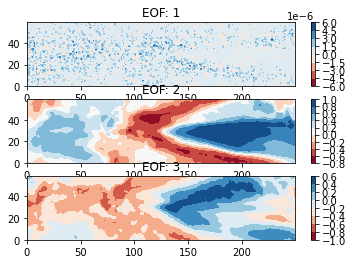

In [29]:
nrows=3
ncols=1
#clevs=np.arange(-20,21,10)

for i in np.arange(3):
    plt.subplot(nrows,ncols,i+1)
    eofnorm=s_eofs_da['sst'][i,:,:]
    plt.contourf(eofnorm,cmap='RdBu')
    plt.title('EOF: '+str(i+1))
    plt.colorbar()